In [100]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Dense, Activation
from keras.callbacks import EarlyStopping

from keras.utils import np_utils, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import pandas as pd

from datetime import datetime,timedelta
import matplotlib.pyplot as plt

# load data

In [153]:
def get_ugrd_data(year, lon, lat):
    csv_dir_path="../data/csv"
    file_path="{0}/{1}/{2}".format(csv_dir_path, lon, lat)

    ugrd_file_name="{0}/{1}_{2}_UGRD_{3}.csv".format(file_path, lon, lat, year)
    ugrd_data = np.genfromtxt(ugrd_file_name, delimiter=",", dtype='float')
    return ugrd_data[:,1]

def get_vgrd_data(year, lon, lat):
    csv_dir_path="../data/csv"
    file_path="{0}/{1}/{2}".format(csv_dir_path, lon, lat)

    vgrd_file_name="{0}/{1}_{2}_VGRD_{3}.csv".format(file_path, lon, lat, year)
    vgrd_data = np.genfromtxt(vgrd_file_name, delimiter=",", dtype='float')
    return vgrd_data[:,1]

lons=["139.2500", "139.3125", "139.3750", "139.4375"]
lats=["35.20", "35.25", "35.30", "35.35", "35.40"]
# lons=["139.3125"]
# lats=["35.30"]

data_msm = pd.DataFrame()

for year in range(2013, 2018):
    data_msm_year = pd.DataFrame()
    data_msm_year["time"] = pd.date_range('{0}-07-01 9:00:00'.format(year), periods=1488, freq='H')
    i = 0
    for lon in lons:
        for lat in lats:
            data_msm_year["UGRD_{0}".format(i)] = get_ugrd_data(year, lon, lat)
            data_msm_year["VGRD_{0}".format(i)] = get_vgrd_data(year, lon, lat)
            i = i + 1
    data_msm = pd.concat([data_msm, data_msm_year])
data_msm = data_msm.reset_index(drop=True)

In [154]:
avg_10min_data_path = "../data/hiratsuka/avg_10min"
prediction_delta =  10 # 何分間後を予測するか

data_hiratsuka = pd.DataFrame()
for year in range(2013, 2018):
    data_path = "{0}/{1}".format(avg_10min_data_path, year)
    data_hiratsuka_year = pd.DataFrame(columns=["UGRD", "VGRD"])
    for month in range(7, 8 + 1):
        for day in range(1, 31 + 1):
            file_name = "{0}{1:02d}{2:02d}.csv".format(year, month, day)
            file_dath = "{0}/{1}".format(data_path, file_name)

            data_day = pd.read_csv(file_dath, header=0)
            data_hiratsuka_year = pd.concat([data_hiratsuka_year, data_day[["UGRD", "VGRD"]]])
            
    data_hiratsuka_year["time"] = pd.date_range('{0}-07-01 00:00:00'.format(year), periods=8928 ,freq='10min')
    # 平塚データに1時間後の正解データを追加
    data_hiratsuka_1h_later = data_hiratsuka_year.shift(int(-prediction_delta/10))
    data_hiratsuka_1h_later.columns = ["UGRD_later", "VGRD_later", "time_later"]
    data_hiratsuka_year = pd.concat([data_hiratsuka_year, data_hiratsuka_1h_later], axis=1)
    
    data_hiratsuka = pd.concat([data_hiratsuka, data_hiratsuka_year])
data_hiratsuka = data_hiratsuka.reset_index(drop = True)

In [155]:
# データ欠損
data_msm.shape, data_msm.dropna().shape, data_hiratsuka.shape, data_hiratsuka.dropna().shape

((7440, 41), (7440, 41), (44640, 6), (44031, 6))

In [156]:
# 平塚欠損データ（元データが欠損しているもの）
data_hiratsuka[data_hiratsuka[["UGRD", "VGRD", "time"]].isnull().any(1)]

,UGRD,VGRD,time,UGRD_later,VGRD_later,time_later
3105,NaN,NaN,2013-07-22 13:30:00,NaN,NaN,2013-07-22 13:40:00
3106,NaN,NaN,2013-07-22 13:40:00,-1.357125,7.443811,2013-07-22 13:50:00
8928,NaN,NaN,2014-07-01 00:00:00,NaN,NaN,2014-07-01 00:10:00
8929,NaN,NaN,2014-07-01 00:10:00,NaN,NaN,2014-07-01 00:20:00
8930,NaN,NaN,2014-07-01 00:20:00,NaN,NaN,2014-07-01 00:30:00
8931,NaN,NaN,2014-07-01 00:30:00,NaN,NaN,2014-07-01 00:40:00
8932,NaN,NaN,2014-07-01 00:40:00,NaN,NaN,2014-07-01 00:50:00
8933,NaN,NaN,2014-07-01 00:50:00,NaN,NaN,2014-07-01 01:00:00
8934,NaN,NaN,2014-07-01 01:00:00,NaN,NaN,2014-07-01 01:10:00
8935,NaN,NaN,2014-07-01 01:10:00,NaN,NaN,2014-07-01 01:20:00


# format data


In [157]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)
data_msm_amp

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,UGRD_15,VGRD_15,UGRD_16,VGRD_16,UGRD_17,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829


In [158]:
data = pd.merge(data_msm_amp, data_hiratsuka, how='outer')
# (62*24*6+9*6)*5=44910 rows
data = data.dropna()
data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19,UGRD,VGRD,UGRD_later,VGRD_later,time_later
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.373967,0.643112,1.424892,0.971913,2013-07-01 09:10:00
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.424892,0.971913,1.296973,1.553636,2013-07-01 09:20:00
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.296973,1.553636,1.002564,1.733061,2013-07-01 09:30:00
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.002564,1.733061,0.770078,1.812200,2013-07-01 09:40:00
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,0.770078,1.812200,0.533275,1.838867,2013-07-01 09:50:00
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,0.533275,1.838867,0.521693,1.736634,2013-07-01 10:00:00
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.521693,1.736634,0.576053,1.856262,2013-07-01 10:10:00
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.576053,1.856262,0.820446,1.913099,2013-07-01 10:20:00
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.820446,1.913099,1.310781,1.704048,2013-07-01 10:30:00
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,1.310781,1.704048,2.186517,1.461793,2013-07-01 10:40:00


# training

In [159]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

test_data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19,UGRD,VGRD,UGRD_later,VGRD_later,time_later
35712,2017-07-01 09:00:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.461566,-4.880211,-1.734624,-5.027068,2017-07-01 09:10:00
35713,2017-07-01 09:10:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.734624,-5.027068,-1.706208,-5.096804,2017-07-01 09:20:00
35714,2017-07-01 09:20:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.706208,-5.096804,-1.277506,-4.503880,2017-07-01 09:30:00
35715,2017-07-01 09:30:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.277506,-4.503880,-2.104033,-3.746856,2017-07-01 09:40:00
35716,2017-07-01 09:40:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-2.104033,-3.746856,-1.627120,-2.515108,2017-07-01 09:50:00
35717,2017-07-01 09:50:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.627120,-2.515108,-1.338525,-3.033009,2017-07-01 10:00:00
35718,2017-07-01 10:00:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-1.338525,-3.033009,-1.346466,-2.380519,2017-07-01 10:10:00
35719,2017-07-01 10:10:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-1.346466,-2.380519,-0.957121,0.136084,2017-07-01 10:20:00
35720,2017-07-01 10:20:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-0.957121,0.136084,-2.220179,-0.488646,2017-07-01 10:30:00
35721,2017-07-01 10:30:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-2.220179,-0.488646,-2.088313,-1.862035,2017-07-01 10:40:00


In [160]:
input_columns = []
input_columns.append("UGRD")
input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

In [161]:
i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	4.093672,	4.705599
1,	139.2500,	35.25,	3.586880,	4.771220
2,	139.2500,	35.30,	4.095028,	8.509534
3,	139.2500,	35.35,	4.182185,	13.447924
4,	139.2500,	35.40,	4.013017,	13.929600
5,	139.3125,	35.20,	4.284316,	5.136563
6,	139.3125,	35.25,	3.561631,	4.527307
7,	139.3125,	35.30,	3.443973,	5.989364
8,	139.3125,	35.35,	4.089683,	10.580072
9,	139.3125,	35.40,	4.390033,	11.549000
10,	139.3750,	35.20,	4.554881,	5.573179
11,	139.3750,	35.25,	3.743590,	4.916531
12,	139.3750,	35.30,	3.282919,	5.157921
13,	139.3750,	35.35,	4.162677,	9.041543
14,	139.3750,	35.40,	4.637895,	10.818812
15,	139.4375,	35.20,	4.881116,	5.931921
16,	139.4375,	35.25,	4.066594,	5.266195
17,	139.4375,	35.30,	3.362148,	5.416723
18,	139.4375,	35.35,	4.198095,	9.226842
19,	139.4375,	35.40,	4.666385,	11.138285


In [164]:
model_v = Sequential()
model_v.add(Dense(100, input_dim = 42))
model_v.add(Activation('relu'))
# model_v.add(Dense(10))
# model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4300      
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 4,401
Trainable params: 4,401
Non-trainable params: 0
_________________________________________________________________


In [165]:
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), epochs = 100)

Epoch 1/100
34942/34942 [==============================] - 3s - loss: 1.1233     
Epoch 2/100
34942/34942 [==============================] - 3s - loss: 0.6041     
Epoch 3/100
34942/34942 [==============================] - 3s - loss: 0.6058     
Epoch 4/100
34942/34942 [==============================] - 3s - loss: 0.5945     
Epoch 5/100
34942/34942 [==============================] - 3s - loss: 0.5894     
Epoch 6/100
34942/34942 [==============================] - 3s - loss: 0.5976     
Epoch 7/100
34942/34942 [==============================] - 3s - loss: 0.5827     
Epoch 8/100
34942/34942 [==============================] - 3s - loss: 0.5820     
Epoch 9/100
34942/34942 [==============================] - 3s - loss: 0.5762     
Epoch 10/100
34942/34942 [==============================] - 3s - loss: 0.5742     
Epoch 11/100
34942/34942 [==============================] - 3s - loss: 0.5728     
Epoch 12/100
34942/34942 [==============================] - 3s - loss: 0.5694     
Epoch 13/100


KeyboardInterrupt: 

In [170]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

0.48326532224687385

#  visualization

In [204]:
def plot_wind(data_array, column_array, label_array, start=None, end=None):
    
    fig = plt.figure(figsize=(18, 12), dpi=80)
    ax1 = fig.add_subplot(2,1,1)
    
    if start is not None and end is not None:
        data_array_ = []
        for data in data_array:
            data_ = data.query('time >= \"{0}\" & time < \"{1}\"'.format(start, end))
            data_array_.append(data_)
        data_array = data_array_
    
    for (data, column, label) in zip(data_array, column_array, label_array) :
        ax1.plot(data["time"], data[column], label = label)

    plt.legend()
    plt.show()

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


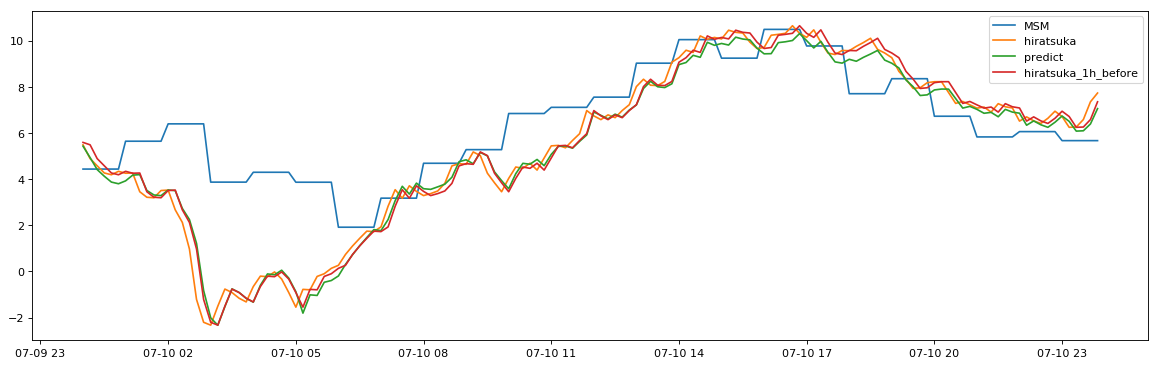

In [208]:
start = datetime(2017,7,10,0,0,0)
end = datetime(2017,7,11,0,0,0)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(minutes=10)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)